In [1]:
#%conda install -c conda-forge yfinance matplotlib tensorflow scikit-learn
#%pip install pandas scikit-learn yfinance matplotlib tensorflow
import json
import numpy as np
import os
import locale
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

# Data Source
import yfinance as yf
import matplotlib.pyplot as plt

from stock_modules.stock_io import (read_tickers_from_excel,
                                    get_histories)

# Figures
from stock_modules.stock_plot import plot_numpy_arr_cols
if not os.path.exists("./figures"):
    os.mkdir("./figures")

In [2]:
ENCODING = locale.getpreferredencoding()
DF_PATH = "HEL_12-10-21to08-11-23.csv"
HISTORY_ARRAY_PATH = "./histories_arr.npy"
MODEL_PATH = "./model.h5"
SELECTED_TICKERS_PATH = "./TICKERS_TO_FOLLOW.json"
SELECTED_TICKERS = json.load(open(SELECTED_TICKERS_PATH, "r", encoding=ENCODING))
DATAFRAME = pd.read_csv(DF_PATH, encoding=ENCODING)
DATAFRAME.set_index("date", inplace=True)
HAS_TIMEDELTA = "Time Delta" in DATAFRAME.columns
# ind transformation tells the label of each index in the np_arr_test
IND_CONVERSION = {i: ticker for i, ticker in enumerate(DATAFRAME.columns) if ticker in SELECTED_TICKERS}
IND_CONVERSION = {i: ticker for i, ticker in enumerate(IND_CONVERSION.values())}
print("Selected tickers: \n", SELECTED_TICKERS)
print("Dataframe columns: \n", DATAFRAME.columns)
print("Dataframe shape: ", DATAFRAME.shape)
print("Dataframe head: \n", DATAFRAME.head(2))
print(f"Index conversion: \n {IND_CONVERSION}")

Selected tickers: 
 ['ALBBV.HE', 'CGCBV.HE', 'EQV1V.HE', 'KNEBV.HE', 'ORNBV.HE', 'OLVAS.HE', 'DETEC.HE', 'PON1V.HE', 'ORNAV.HE', 'VALMT.HE', 'NESTE.HE', 'HUH1V.HE', 'REG1V.HE', 'VAIAS.HE']
Dataframe columns: 
 Index(['Time Delta', 'REG1V.HE', 'NESTE.HE', 'ORNBV.HE', 'KNEBV.HE',
       'OLVAS.HE', 'HUH1V.HE', 'DETEC.HE', 'ORNAV.HE', 'CGCBV.HE', 'VAIAS.HE',
       'ALBBV.HE', 'VALMT.HE', 'EQV1V.HE', 'PON1V.HE'],
      dtype='object')
Dataframe shape:  (4389, 15)
Dataframe head: 
                      Time Delta   REG1V.HE   NESTE.HE   ORNBV.HE   KNEBV.HE  \
date                                                                          
2021-10-12 07:00:00           1  55.950001  41.820000  35.689999  60.220001   
2021-10-12 08:00:00           1  55.799999  41.720001  35.630001  60.419998   

                      OLVAS.HE   HUH1V.HE  DETEC.HE   ORNAV.HE   CGCBV.HE  \
date                                                                        
2021-10-12 07:00:00  53.099998  38.529999     

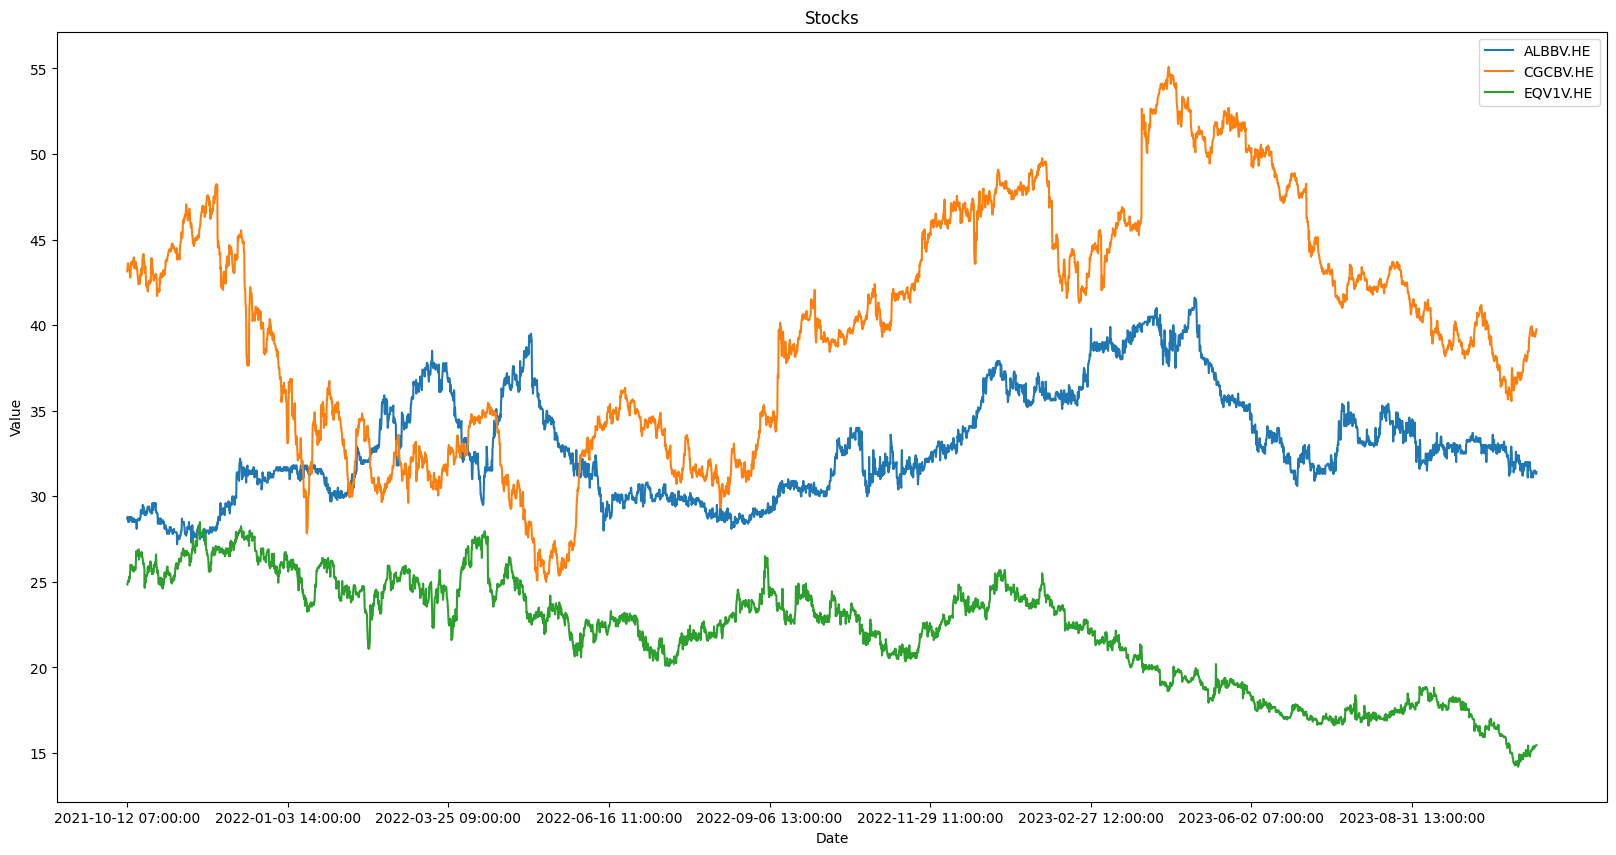

In [3]:
# Show values or not
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Stocks")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
for ticker in SELECTED_TICKERS[:3]:
    ax.plot(DATAFRAME.index, DATAFRAME[ticker], label=ticker)
# Change xticks
ax.set_xticks(DATAFRAME.index[::500])
ax.legend()
plt.show()

In [4]:
# If we are predicting the next price, we just minmax scale the data
TEST_FRAC = 0.2

df = DATAFRAME.copy()
if HAS_TIMEDELTA:
    td_col = df["Time Delta"]
    df.drop("Time Delta", axis=1, inplace=True)
diff_df = df.diff()
# The first row is NaN, so lets copy the second row there
diff_df.iloc[0, :] = diff_df.iloc[1, :]
# Add back the Time Delta column
if HAS_TIMEDELTA:
    diff_df["Time Delta"] = td_col
    # Make Time Delta the first column
    cols = diff_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    diff_df = diff_df[cols]
transformed_df = diff_df

print("Transformed df: \n", transformed_df.head(2))
print("Transformed df shape: ", transformed_df.shape)

Transformed df: 
                      Time Delta  REG1V.HE  NESTE.HE  ORNBV.HE  KNEBV.HE  \
date                                                                      
2021-10-12 07:00:00           1 -0.150002 -0.099998 -0.059998  0.199997   
2021-10-12 08:00:00           1 -0.150002 -0.099998 -0.059998  0.199997   

                     OLVAS.HE  HUH1V.HE  DETEC.HE  ORNAV.HE  CGCBV.HE  \
date                                                                    
2021-10-12 07:00:00  0.200001  0.030003       0.0       0.0  0.360001   
2021-10-12 08:00:00  0.200001  0.030003       0.0       0.0  0.360001   

                     VAIAS.HE  ALBBV.HE  VALMT.HE  EQV1V.HE  PON1V.HE  
date                                                                   
2021-10-12 07:00:00 -0.200001  0.099998  0.139999       0.1  0.049999  
2021-10-12 08:00:00 -0.200001  0.099998  0.139999       0.1  0.049999  
Transformed df shape:  (4389, 15)


In [7]:
# Reload modules
%load_ext autoreload
%autoreload 2

from stock_modules.stock_transform import (histories_to_array,
                                           create_batch_xy)
MHOURS = 12
OUTPUT_SCALE = (0,1)
# Batch X data into sequences of length MHOURS (from T to T+n), and Y data
# into sequences of length 1 (T+n+1)
X, Y = create_batch_xy(MHOURS, DATAFRAME, overlap=True, y_updown=False, y_direction=True, threshold=0.002, to_onehot=True)

# Swap 2nd and 3rd axes in Y
Y = np.swapaxes(Y, 1, 2)

X_og = X.copy()
Y_og = Y.copy()

test_sz = int(X.shape[0] * TEST_FRAC)

# Split the data into train and test sets
X_train = X[:-test_sz,:,:]
Y_train = Y[:-test_sz,:,:]
X_test = X[-test_sz:,:,:]
Y_test = Y[-test_sz:,:,:]

print(f"One input shape: {X_train[0].shape}")
print(f"One output shape: {Y_train[0].shape}")



print(f"Example input: \n {X_train[0]}")
print(f"Example output: \n {Y_train[0]}")
print(f"Input shape: {X_train.shape}")
print(f"Output shape: {Y_train.shape}")
# Count the number of ups/downs/flats in Y_train
print(f"Y_train: {Y_train}")
print(f"Number of down classes: {np.sum(Y_train[:,0,:])}")
print(f"Number of flat classes: {np.sum(Y_train[:,1,:])}")
print(f"Number of up classes: {np.sum(Y_train[:,2,:])}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[ 1.         55.95000076 41.81999969 ... 36.45999908 24.85000038
  39.15000153]
 [ 1.         55.79999924 41.72000122 ... 36.59999847 24.95000076
  39.20000076]
 [ 1.         55.70000076 42.06000137 ... 36.40000153 25.
  39.5       ]
 ...
 [ 1.         22.81999969 31.82999992 ... 22.60000038 15.43999958
  24.        ]
 [ 1.         22.89999962 31.84000015 ... 22.65999985 15.46000004
  23.70000076]
 [-1.         23.02000046 31.89999962 ... 22.78000069 15.46000004
  24.04999924]]

            Batched 'histories_arr' ((4389, 15)) to 'X'
            ((4377, 12, 15)) and 'Y' ((4377, 15, 3))
            
One input shape: (12, 15)
One output shape: (3, 15)
Example input: 
 [[ 1.         55.95000076 41.81999969 35.68999863 60.22000122 53.09999847
  38.52999878 23.         38.04999924 43.13999939 46.15000153 28.70000076
  36.45999908 24.85000038 39.15000153]
 [ 1.         55.79999924 41.72000122 35.63000107

In [10]:
%load_ext autoreload
%autoreload 2
from stock_modules.stock_ml import create_price_prediction_model, create_updown_prediction_model, create_updown_prediction_model_dense, create_direction_prediction_model

MODEL_PATH = "./model.h5"
RENEW_MODEL = True
PATIENCE = 10
EPOCHS = 200
BATCH_SIZE = 128

class SkipTDLoss(tf.keras.losses.Loss):
    """ A loss funciton, that calculates the given loss for all columns except the first one (Time Delta)
    """
    def __init__(self, base_loss_fun, **kwargs):
        super().__init__(**kwargs)
        self.base_loss_fun = base_loss_fun
    
    def call(self, y_true, y_pred):
        # Skip first column
        return self.base_loss_fun(y_true[:,1:], y_pred[:,1:])
    
class MultiSoftmaxLoss(tf.keras.losses.Loss):
    """ Calculates the sum of the softmax losses for each one-hot prediction.
    So input is (batch_size, nhours, nstocks), and output is (batch_size, 3, nstocks)
    The softmax loss from each one-hot prediction is summed together.
    """
    def __init__(self):
        super().__init__()
        self.loss_fun = tf.keras.losses.CategoricalCrossentropy()
    
    def call(self, y_true, y_pred):
        pred_losses = []
        # Calculate the softmax loss for each one-hot prediction
        # Each prediction and y_true is (nstocks, 3), and we want to calculate the loss on all columns and then sum them
        print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
        for i in range(y_true.shape[1]):
            pred_losses.append(self.loss_fun(y_true[:,i,:], y_pred[:,i,:]))
        # Calc the mean
        return tf.reduce_mean(pred_losses)

LOSS_FUN = MultiSoftmaxLoss()
transformed_np_arr = transformed_df.to_numpy()

# Fit model by showing it the data from the last MHOURS hours, and
# predicting the next hour
if os.path.exists(MODEL_PATH) and not RENEW_MODEL:
    if HAS_TIMEDELTA:
        skip_td_loss = SkipTDLoss(LOSS_FUN)
        model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"SkipTDLoss": skip_td_loss})
    else:
        model = tf.keras.models.load_model(MODEL_PATH)
else:
    #model = create_updown_prediction_model(MHOURS, transformed_np_arr.shape[1], output_scale=OUTPUT_SCALE)
    model = create_direction_prediction_model(MHOURS, transformed_np_arr.shape[1])
    print(model.summary())
    # Show example output of model
    test_pred = np.array(model.predict(X_train[0:1,:,:])).squeeze()
    print(f"Example model output for single stock: \n {test_pred}")
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=LOSS_FUN, optimizer=opt, metrics=["accuracy", "mae"])
    if HAS_TIMEDELTA:
        model.compile(loss=SkipTDLoss(LOSS_FUN), optimizer="adam", metrics=["accuracy", "mae"])
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        restore_best_weights=True
    )
    print(f"Starting training for {EPOCHS} epochs, with batch size {BATCH_SIZE} and data shapes {X_train.shape} and {Y_train.shape}")
    model.fit(X_train, Y_train,
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            validation_data=(X_test, Y_test), verbose=1,
            callbacks=[early_stop], shuffle=True)
    model.save(MODEL_PATH)
# Show true values and predictions
Y_pred = model.predict(X_test)
if HAS_TIMEDELTA:
    Y_pred = Y_pred[:,1:]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 15)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 12, 64)            20480     
                                                                 
 lstm_3 (LSTM)               (None, 12, 16)            5184      
                                                                 
 flatten_1 (Flatten)         (None, 192)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                12352     
                                                                 
 dense_3 (Dense)             (None, 45)                2925      
                                     

In [11]:
print("Y_pred: \n", Y_pred)
print("Y_test: \n", Y_test)

# Calculate the accuracy of up-down-flat predictions
# So predict the up/down of each stock, at each time on the test data (Y_pred)
# and compare it to the true values (Y_test)
for stock_idx in range(Y_pred.shape[2] -1 if HAS_TIMEDELTA else Y_pred.shape[2]):
    # Get the up/down/flat predictions for the stock
    direction_preds = Y_pred[:,:,stock_idx]
    #print(f"direction_preds: \n {direction_preds}")
    # Get the true up/down/flat values for the stock
    direction_true = Y_test[:,:,stock_idx]
    # Get the predicted up/down/flat class
    direction_preds = np.argmax(direction_preds, axis=1)
    # Get the true up/down/flat class
    direction_true = np.argmax(direction_true, axis=1)
    # Calculate the accuracy
    accuracy = np.sum(direction_preds == direction_true) / len(direction_preds)
    print(f"Up/Down/Flat accuracy for stock {IND_CONVERSION[stock_idx]}: {accuracy}")


Y_pred: 
 [[[0.5207839  0.34071633 0.33333334 ... 0.38548294 0.23685548 0.33333334]
  [0.23960805 0.37124178 0.33333334 ... 0.30725855 0.41332692 0.33333334]]

 [[0.43064412 0.35082814 0.33333334 ... 0.38264647 0.22795074 0.33333334]
  [0.28467795 0.35311195 0.33333334 ... 0.30867675 0.4310115  0.33333334]]

 [[0.35827422 0.38521096 0.33333334 ... 0.39057136 0.24919647 0.33333334]
  [0.32086292 0.3111811  0.33333334 ... 0.30471432 0.43224874 0.33333334]]

 ...

 [[0.66856307 0.28755718 0.33333334 ... 0.33953106 0.21179591 0.33333334]
  [0.16571847 0.35483477 0.33333334 ... 0.3164371  0.4135703  0.33333334]]

 [[0.6173487  0.29535142 0.33333334 ... 0.34505406 0.21426141 0.33333334]
  [0.19132562 0.3607016  0.33333334 ... 0.32367626 0.44574127 0.33333334]]

 [[0.58879554 0.31159025 0.33333334 ... 0.36088786 0.21405771 0.33333334]
  [0.20560223 0.3807988  0.33333334 ... 0.31955606 0.4416265  0.33333334]]]
Y_test: 
 [[[0. 0. 1. ... 0. 0. 0.]
  [1. 1. 0. ... 0. 1. 1.]
  [0. 0. 0. ... 1. 0. 

In [12]:

from invest_strategies import (calculate_optimal_invest_strategy,
                               calculate_profit_on_invest_strategy,
                               strategy_mask_from_price_model,
                               strategy_mask_from_updown_model,
                               strategy_mask_from_direction_model)

# Calculate profit by optimal strategy (theoretical) vs using model to predict
test_sz = int(DATAFRAME.shape[0] * TEST_FRAC)
df_test = DATAFRAME.iloc[-test_sz:,:].copy()
if HAS_TIMEDELTA:
    df_test.drop("Time Delta", axis=1, inplace=True)
np_arr_test = df_test.to_numpy()
print("np_arr_test data shape: ", np_arr_test.shape)

optimal_trading_mask = calculate_optimal_invest_strategy(np_arr_test)
print(f"Optimal mask 4th stock: \n {optimal_trading_mask[:,2]}")
profit_optimal = calculate_profit_on_invest_strategy(np_arr_test, optimal_trading_mask)
print(f"Optimal strategy matrix shape: {optimal_trading_mask.shape}")
print(f"Profit by optimal strategy on test data: {profit_optimal}")

# To calculate the mask for the model, we need to give the data in the same format as it was trained in
transformed_df_test = transformed_df.iloc[-test_sz:,:]
transformed_np_arr_test = transformed_df_test.to_numpy()
print("transformed_np_arr_test data shape: ", transformed_np_arr_test.shape)
print(transformed_np_arr_test[0:2,:])
prediction_trading_mask = strategy_mask_from_direction_model(transformed_np_arr_test, MHOURS, model)

if HAS_TIMEDELTA:
    prediction_trading_mask = prediction_trading_mask[:,1:]

print(f"Prediction mask 2nd stock: \n {prediction_trading_mask[:,2]}")
if HAS_TIMEDELTA:
    profit_pred_model = calculate_profit_on_invest_strategy(np_arr_test[:,1:], prediction_trading_mask)
else:
    profit_pred_model = calculate_profit_on_invest_strategy(np_arr_test, prediction_trading_mask)
print(f"Prediction strategy matrix shape: {prediction_trading_mask.shape}")
print(f"Profit by predicting the next hour using the model: {profit_pred_model}")

np_arr_test data shape:  (877, 14)
Optimal mask 4th stock: 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

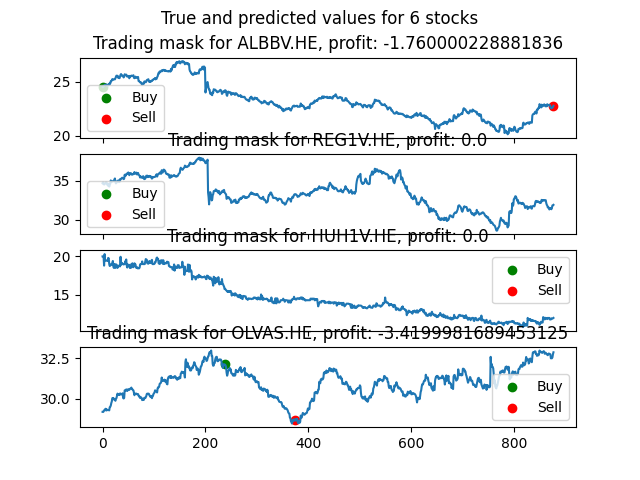

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: title={'center': 'Trading mask for ALBBV.HE, profit: -1.760000228881836'}>,
        <Axes: title={'center': 'Trading mask for REG1V.HE, profit: 0.0'}>,
        <Axes: title={'center': 'Trading mask for HUH1V.HE, profit: 0.0'}>,
        <Axes: title={'center': 'Trading mask for OLVAS.HE, profit: -3.4199981689453125'}>],
       dtype=object))

In [14]:
%matplotlib widget
from stock_modules.stock_plot import plot_strategy_based_on_predictions,plot_mask_and_data
stock_indices = np.random.choice(np.arange(len(IND_CONVERSION)), 4, replace=False)
part_mask = prediction_trading_mask[:,stock_indices]

if HAS_TIMEDELTA:
    part_price = np_arr_test[:,1:][:,stock_indices]
else:
    part_price = np_arr_test[:,stock_indices]
ind_conversion = {si : IND_CONVERSION[i] for si, i in enumerate(stock_indices)}
plot_mask_and_data(part_mask, part_price, ind_conversion)